# Training a Boltzmann Generator for Alanine Dipeptide

This notebook introduces basic concepts behind `bgflow`. 

It shows how to build an train a Boltzmann generator for a small peptide. The most important aspects it will cover are

- retrieval of molecular training data
- defining a internal coordinate transform
- defining normalizing flow classes
- combining different normalizing flows
- training a Boltzmann generator via NLL and KLL

The main purpose of this tutorial is to introduce the implementation. The network design is optimized for educational purposes rather than good performance. In the conlusions, we will discuss some aspects of the generator that are not ideal and outline improvements.

## Some Preliminaries

We instruct jupyter to reload any imports automatically and define the device and datatype, on which we want to perform the computations.

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")



## Load the Data and the Molecular System

Molecular trajectories and their corresponding potential energy functions are available from the `bgmol` repository.

In [5]:
import os
from bgmol.datasets import Ala2TSF300, Ala2TSF1000

# Load data at 300K
is_data_here = os.path.isfile("Ala2TSF300.npy")
dataset = Ala2TSF300(download=(not is_data_here), read=True)

# Load data at 1000K
# is_data_here = os.path.isfile("Ala2TSF1000.npy")
# dataset = Ala2TSF1000(download=(not is_data_here), read=True)

system = dataset.system
coordinates = dataset.coordinates
temperature = dataset.temperature
dim = dataset.dim

Using downloaded and verified file: /tmp/alanine-dipeptide-nowater.pdb


The energy model is a `bgflow.Energy` that wraps around OpenMM. The `n_workers` argument determines the number of openmm contexts that are used for energy evaluations. In notebooks, we set `n_workers=1` to avoid hickups. In production, we can omit this argument so that `n_workers` is automatically set to the number of CPU cores.

In [6]:
target_energy = dataset.get_energy_model(n_workers=1)

### Visualize Data: Ramachandran Plot for the Backbone Angles

In [7]:
import numpy as np
import mdtraj as md 
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_phi_psi(ax, trajectory, system):
    if not isinstance(trajectory, md.Trajectory):
        trajectory = md.Trajectory(
            xyz=trajectory.cpu().detach().numpy().reshape(-1, 22, 3), 
            topology=system.mdtraj_topology
        )
    phi, psi = system.compute_phi_psi(trajectory)
    
    ax.hist2d(phi, psi, 50, norm=LogNorm())
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel("$\phi$")
    _ = ax.set_ylabel("$\psi$")
    
    return trajectory

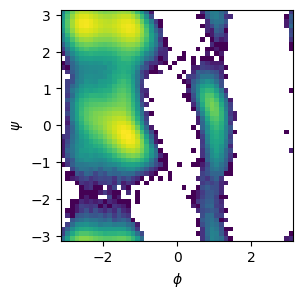

In [8]:
if main:
    fig, ax = plt.subplots(figsize=(3,3))
    _ = plot_phi_psi(ax, dataset.trajectory, system)

## Split Data and Randomly Permute Samples

In [9]:
n_train = len(dataset)//2
n_test = len(dataset) - n_train
permutation = np.random.permutation(n_train)

all_data = coordinates.reshape(-1, dataset.dim)
training_data = torch.tensor(all_data[permutation]).to(ctx)
test_data = torch.tensor(all_data[permutation + n_train]).to(ctx)

In [10]:
example = training_data[0]
example.shape
example.reshape(-1, 3)

tensor([[ 0.6218,  0.2778,  0.2715],
        [ 0.5742,  0.2064,  0.2042],
        [ 0.4714,  0.1811,  0.2299],
        [ 0.6282,  0.1127,  0.1907],
        [ 0.5874,  0.2667,  0.0635],
        [ 0.6789,  0.2351, -0.0128],
        [ 0.4941,  0.3585,  0.0313],
        [ 0.4131,  0.3605,  0.0916],
        [ 0.4901,  0.4195, -0.1069],
        [ 0.5854,  0.4072, -0.1585],
        [ 0.3890,  0.3486, -0.2010],
        [ 0.3998,  0.2428, -0.1770],
        [ 0.2839,  0.3724, -0.1851],
        [ 0.4117,  0.3698, -0.3055],
        [ 0.4748,  0.5767, -0.0883],
        [ 0.3833,  0.6245, -0.0187],
        [ 0.5661,  0.6603, -0.1541],
        [ 0.6304,  0.6162, -0.2184],
        [ 0.5955,  0.8015, -0.1137],
        [ 0.5115,  0.8569, -0.1555],
        [ 0.5876,  0.8080, -0.0052],
        [ 0.6926,  0.8395, -0.1455]], device='cuda:0')

## Define the Internal Coordinate Transform

Rather than generating all-Cartesian coordinates, we use a mixed internal coordinate transform.
The five central alanine atoms will serve as a Cartesian "anchor", from which all other atoms are placed with respect to internal coordinates (IC) defined through a z-matrix. We have deposited a valid `z_matrix` and the corresponding `rigid_block` in the `dataset.system` from `bgmol`.

In [11]:
import bgflow as bg

In [12]:
# throw away 6 degrees of freedom (rotation and translation)
dim_cartesian = len(system.rigid_block) * 3 - 6
dim_bonds = len(system.z_matrix)
dim_angles = dim_bonds
dim_torsions = dim_bonds

In [13]:
coordinate_transform = bg.MixedCoordinateTransformation(
    data=training_data, 
    z_matrix=system.z_matrix,
    fixed_atoms=system.rigid_block,
    keepdims=dim_cartesian, 
    normalize_angles=True,
).to(ctx)

For demonstration, we transform the first 3 samples from the training data set into internal coordinates as follows:

In [14]:
bonds, angles, torsions, cartesian, dlogp = coordinate_transform.forward(training_data[:3])
bonds.shape, angles.shape, torsions.shape, cartesian.shape, dlogp.shape

(torch.Size([3, 17]),
 torch.Size([3, 17]),
 torch.Size([3, 17]),
 torch.Size([3, 9]),
 torch.Size([3, 1]))

## Prior Distribution

The next step is to define a prior distribution that we can easily sample from. The normalizing flow will be trained to transform such latent samples into molecular coordinates. Here, we just take a normal distribution, which is a rather naive choice for reasons that will be discussed in other notebooks.

In [15]:
dim_ics = dim_bonds + dim_angles + dim_torsions + dim_cartesian
mean = torch.zeros(dim_ics).to(ctx) 
# passing the mean explicitly to create samples on the correct device
prior = bg.NormalDistribution(dim_ics, mean=mean)

## Normalizing Flow

Next, we set up the normalizing flow by stacking together different neural networks. For now, we will do this in a rather naive way, not distinguishing between bonds, angles, and torsions. Therefore, we will first define a flow that splits the output from the prior into the different IC terms.

### Split Layer

In [16]:
split_into_ics_flow = bg.SplitFlow(dim_bonds, dim_angles, dim_torsions, dim_cartesian)

In [17]:
# test
_ics = split_into_ics_flow(prior.sample(3))[:-1]
coordinate_transform.forward(*_ics, inverse=True)[0].shape

torch.Size([3, 66])

### Coupling Layers

Next, we will set up so-called RealNVP coupling layers, which split the input into two channels and then learn affine transformations of channel 1 conditioned on channel 2. Here we will do the split naively between the first and second half of the degrees of freedom.

In [18]:
class RealNVP(bg.SequentialFlow):
    
    def __init__(self, dim, hidden):
        self.dim = dim
        self.hidden = hidden
        super().__init__(self._create_layers())
    
    def _create_layers(self):
        dim_channel1 =  self.dim//2
        dim_channel2 = self.dim - dim_channel1
        split_into_2 = bg.SplitFlow(dim_channel1, dim_channel2)
        
        layers = [
            # -- split
            split_into_2,
            # --transform
            self._coupling_block(dim_channel1, dim_channel2),
            bg.SwapFlow(),
            self._coupling_block(dim_channel2, dim_channel1),
            # -- merge
            bg.InverseFlow(split_into_2)
        ]
        return layers
        
    def _dense_net(self, dim1, dim2):
        return bg.DenseNet(
            [dim1, *self.hidden, dim2],
            activation=torch.nn.ReLU()
        )
    
    def _coupling_block(self, dim1, dim2):
        return bg.CouplingFlow(bg.AffineTransformer(
            shift_transformation=self._dense_net(dim1, dim2),
            scale_transformation=self._dense_net(dim1, dim2)
        ))
    

In [19]:
RealNVP(dim_ics, hidden=[128]).to(ctx).forward(prior.sample(3))[0].shape

torch.Size([3, 60])

### Boltzmann Generator

Finally, we define the Boltzmann generator.
It will sample molecular conformations by 

1. sampling in latent space from the normal prior distribution,
2. transforming the samples into a more complication distribution through a number of RealNVP blocks (the parameters of these blocks will be subject to optimization),
3. splitting the output of the network into blocks that define the internal coordinates, and
4. transforming the internal coordinates into Cartesian coordinates through the inverse IC transform.

In [20]:
n_realnvp_blocks = 5
layers = []

for i in range(n_realnvp_blocks):
    layers.append(RealNVP(dim_ics, hidden=[128, 128, 128]))
layers.append(split_into_ics_flow)
layers.append(bg.InverseFlow(coordinate_transform))

flow = bg.SequentialFlow(layers).to(ctx)

In [21]:
# test
flow.forward(prior.sample(3))[0].shape

torch.Size([3, 66])

In [22]:
# print number of trainable parameters
"#Parameters:", np.sum([np.prod(p.size()) for p in flow.parameters()])

('#Parameters:', 817250)

In [23]:
generator = bg.BoltzmannGenerator(
    flow=flow,
    prior=prior,
    target=target_energy
)

## Train

Boltzmann generators can be trained in two ways:
1. by matching the density of samples from the training data via the negative log likelihood (NLL), and
2. by matching the target density via the backward Kullback-Leibler loss (KLL).

NLL-based training is faster, as it does not require the computation of molecular target energies. Therefore, we will first train the generator solely by density estimation.

### NLL Training

In [24]:
nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
nll_trainer = bg.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=False
)

In [25]:
if main:
    nll_trainer.train(
        n_iter=20000, 
        data=training_data,
        batchsize=128,
        n_print=1000, 
        w_energy=0.0
    )

1	NLL: -7.0593	
1001	NLL: -174.8073	
2001	NLL: -193.3015	
3001	NLL: -215.1701	
4001	NLL: -213.8927	
5001	NLL: -222.2368	
6001	NLL: -223.6777	
7001	NLL: -218.7667	
8001	NLL: -227.3912	
9001	NLL: -231.8041	
10001	NLL: -231.2101	
11001	NLL: -230.7379	
12001	NLL: -227.4733	
13001	NLL: -237.5045	
14001	NLL: -238.1683	
15001	NLL: -215.0426	
16001	NLL: -239.9178	
17001	NLL: -228.2190	
18001	NLL: -238.9810	
19001	NLL: -233.3817	


To see what the generator has learned so far, let's first create a bunch of samples and compare their backbone angles with the molecular dynamics data. Let's also plot their energies.

In [26]:
def plot_energies(ax, samples, target_energy, test_data):
    sample_energies = target_energy.energy(samples).cpu().detach().numpy()
    md_energies = target_energy.energy(test_data[:len(samples)]).cpu().detach().numpy()
    cut = max(np.percentile(sample_energies, 80), 20)
    
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(sample_energies, range=(-50, cut), bins=40, density=False, label="BG")
    ax2.hist(md_energies, range=(-50, cut), bins=40, density=False, label="MD")
    ax2.set_ylabel(f"Count   [#Samples / {len(samples)}]")
    ax2.legend()

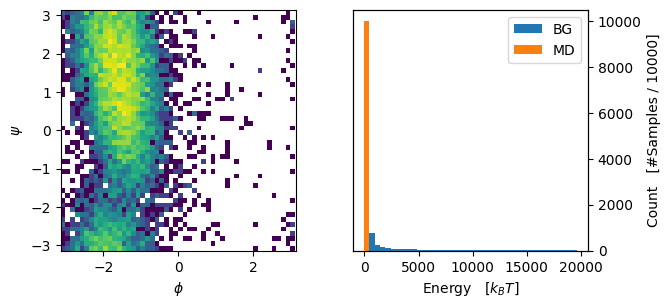

In [27]:
if main:
    
    n_samples = 10000
    samples = generator.sample(n_samples)

    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    fig.tight_layout()

    plot_phi_psi(axes[0], samples, system)
    plot_energies(axes[1], samples, target_energy, test_data)

    del samples

### Mixed Training

The next step is "mixed" training with a combination of NLL and KLL. To retain some of the progress made in the NLL phase, we decrease the learning rate and increase the batch size.

In [28]:
mixed_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
mixed_trainer = bg.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=True
)

Mixed training will be considerably slower. 
To speed it up, you can change the settings for the OpenMM energy when creating the energy model. For example, consider not passing `n_workers=1`.

To avoid large potential energy gradients from singularities, the components of the KL gradient are constrained to (-100, 100). 

In [29]:
if main:
    mixed_trainer.train(
        n_iter=2000, 
        data=training_data,
        batchsize=1000,
        n_print=100, 
        w_energy=0.1,
        w_likelihood=0.9,
        clip_forces=20.0
    )

1	KLL: 173334512.0000	NLL: -240.2753	
101	KLL: 730521664.0000	NLL: 499.0332	
201	KLL: 39019642880.0000	NLL: 864.7253	
301	KLL: 135303536.0000	NLL: 818.1963	
401	KLL: 478408.3438	NLL: 767.2994	
501	KLL: 4271182970880.0000	NLL: 799.4779	
601	KLL: 78102249472.0000	NLL: 974.7872	
701	KLL: 151807888.0000	NLL: 805.3764	
801	KLL: 45090188.0000	NLL: 723.0250	
901	KLL: 1945493.3750	NLL: 563.4889	
1001	KLL: 8475979264.0000	NLL: 371.6136	
1101	KLL: 2000896384.0000	NLL: 255.9729	
1201	KLL: 13870062.0000	NLL: 162.5048	
1301	KLL: 24881518.0000	NLL: 287.5608	
1401	KLL: 29801740.0000	NLL: 81.7110	
1501	KLL: 12918129.0000	NLL: -9.7236	
1601	KLL: 1277813063680.0000	NLL: -74.5028	
1701	KLL: 14048993.0000	NLL: -90.2738	
1801	KLL: 9807907840.0000	NLL: -103.0815	
1901	KLL: 16413149.0000	NLL: -110.2098	


Plot the results:

In [ ]:
if main:
    
    n_samples = 10000
    samples = generator.sample(n_samples)

    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    fig.tight_layout()

    plot_phi_psi(axes[0], samples, system)
    plot_energies(axes[1], samples, target_energy, test_data)

    del samples

With nglview installed, we can also take a look at the samples.

In [ ]:
try:
    import nglview as nv
    widget = nv.show_mdtraj(trajectory)
except:
    widget = None
widget

In [44]:
def transfer_traj(trajectory):
    if not isinstance(trajectory, md.Trajectory):
        trajectory = md.Trajectory(
            xyz=trajectory.cpu().detach().numpy().reshape(-1, 22, 3), 
            topology=system.mdtraj_topology
        )
    return trajectory

In [47]:
import nglview as nv
traj  =transfer_traj(dataset.trajectory)
widget = nv.show_mdtraj(traj)

## Conclusions

This tutorial has introduced the most basic concepts and implementations underlying Boltzmann generators and `bgflow`. That said, the trained networks did not do a particularly good job in reproducing the molecular Boltzmann distribution. Specifically, they only modeled the major modes of the $\phi$ angle and still produced many samples with unreasonably large energies. Let's look at a few shortcomings of the present architecture:

### 1) Unconstrained Internal Coordinates
Bonds, angles, and torsions must not take arbitrary values in principle. Bond lengths need to be positive, angles live in $[0,\pi],$ and torsions are periodic in $[-\pi, \pi].$ Neither those bounds nor the periodicity of torsions distributions have been taken into account by the present Boltzmann generator. The layers of the normalizing flow should be build in a way that preserves these constraints on the ICs.

### 2)  Arbitrary Coupling
The input for the coupling layers was split into two channels rather arbitrarily (first vs. second half). A partial remedy is to define the conditioning in a physically informed manner. Another solution is to augment the base space by momenta, which can be done with augmented normalizing flows (see for instance the notebook on temperature-steering flows).

### 3) RealNVP Layers
Affine coupling layers are well-known to perform poorly in separating modes. This explains that the metastable region around $\phi \approx \pi/2$ was not captured by the generator. Other architectures such as augmented flows or neural spline flows do a better job for complicated, multimodal distributions.

### 4) Training
The generators were only trained for relatively few iterations and performance may improve with longer training and better choices of the learning rate and hyperparameters.